# Proyecto de Movilidad Flujo en Redes

Andrés Rueda López - 201910943

In [ ]:
!pip install seaborn
!pip install networkx
!pip install pulp
!pip install numpy
!pip install pandas
!pip install numpy
!pip install gurobipy

In [1]:
# Importar librerias necesarias
import ast
import pulp as lp
import random
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Sets and Parameters

A continuación se muestra el códgico para una flota de 

## Complejidad de instancias

### Modelación de la demanda

In [ ]:
buses_disponibles = 31
nodos_ruta = 12
capacidad_bus = 50
max_t = 64
ruta = "PRADERA 27"
agrupacion_minutos = 15

In [ ]:
# Algunas inicializaciones de los parametros inyectados.
N = []
A = []
for i in range(nodos_ruta):
    N.append(i)
    A.append((i, i + 1))
N.append(nodos_ruta)
A.append((nodos_ruta, 0))
P =  list(range(1, (1+buses_disponibles)))# Lista de buses
T = list(range(1, (max_t+1)))  # Horizonte temporal de 1 a 19

In [15]:
# Parámetros
tau = {(i, j): 1 for (i, j) in A}  # Tiempo de viaje en cada arco
capacidad_bus = 50  # Capacidad máxima del bus


# Proporción de pasajeros que se bajan en cada nodo
prop_bajada = {}
for i in N:
    prop_bajada[i] =  random.random()


# Parámetro para el estado inicial (sin pasajeros al inicio)
s_inicio = {(p): 0 for p in P}

max_ciclos = int(max(T)/max(N))
demanda_inicial = {(n, t): 0 for n in N for t in T}




# Carga de archivo de demanda

In [16]:
with open(f"./outputs/model_input/{ruta}.csv", "r") as file:
    content = file.read()
demanda = ast.literal_eval(content)

#Eliminar los datos del instante cero
for n in N:
    demanda.pop((n,0), None)

for t in T:
    demanda[0,t] = 0
    demanda[nodos_ruta,t] = 0
    demanda[int(nodos_ruta/2),t] = 0

# Definir M como el máximo de la demanda en todos los nodos y tiempos
M = max(demanda.values()) if demanda else 0  # Asegúrate de que 'demanda' no esté vacío

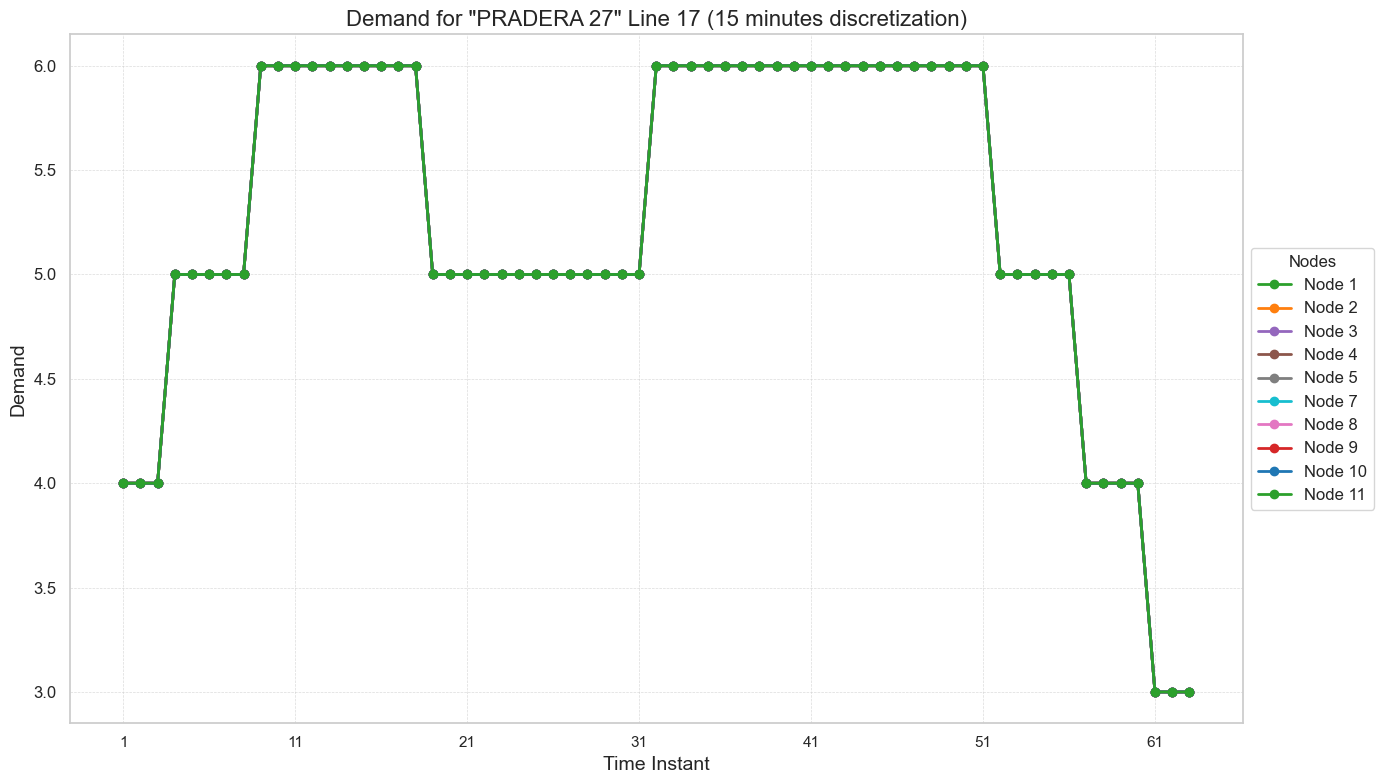

In [17]:

# Aplicar estilo formal de seaborn
sns.set(style="whitegrid")

# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 8))

# Colores para diferenciar los nodos (añadiendo más tonos neutros y grises)
colores = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#7f7f7f', '#bcbd22', '#17becf', '#e377c2', '#d62728']

# Iterar sobre cada nodo y graficar sus demandas
for idx, nodo in enumerate(N):
    if nodo not in [0,nodos_ruta,int(nodos_ruta/2)]:
        # Obtener las demandas para el nodo actual
        demandas = list()
        for instante in T:
            try:
                demandas.append(demanda[(nodo, instante)])
            except KeyError:
                demandas.append(0)
        # Graficar las demandas con colores neutros
        plt.plot(T, demandas, marker='o', linestyle='-', color=colores[idx % len(colores)], label=f'Node {nodo}', linewidth=2)


# Añadir etiquetas y título, mejorando las fuentes
plt.xlabel('Time Instant', fontsize=14)
plt.ylabel('Demand', fontsize=14)
contruct_quotes = f'"{ruta}"'
plt.title(f'Demand for {contruct_quotes} ({agrupacion_minutos} minutes discretization)', fontsize=16)

# Configurar los ticks del eje x para mayor claridad
plt.xticks(ticks=T[::10])
plt.yticks(fontsize=12)

# Añadir una cuadrícula más sutil
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Añadir la leyenda fuera del gráfico para mayor claridad
plt.legend(title="Nodes", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Ajustar el diseño para que no se corten elementos
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [18]:
from gurobipy import Model, GRB

import pulp as lp

gurobi_solver = lp.GUROBI_CMD(
    msg=True,
    options=[
        ('TimeLimit', 3600)   # Establece el límite de tiempo en 60 segundos
    ]
)



In [19]:
# Definición del problema
prob = lp.LpProblem("Optimización_Ruta_Buses", lp.LpMaximize)


# Variables de decisión
x = lp.LpVariable.dicts(
    "x", [(i, j, t, p) for p in P for (i, j) in A for t in T], 0, 1, cat='Binary'
)
y = lp.LpVariable.dicts(
    "y", [(i, j, t, p) for p in P for (i, j) in A for t in T], 0, 1, cat='Binary'
)
z = lp.LpVariable.dicts(
    "z", [(n, t, p) for p in P for n in N for t in T], 0, 1, cat='Binary'
)
w = lp.LpVariable.dicts(
    "w", [(n, t, p) for p in P for n in N for t in T], 0, None, cat='Integer'
)
o = lp.LpVariable.dicts(
    "o", [(n, t, p) for p in P for n in N for t in T], 0, None, cat='Integer'
)
s = lp.LpVariable.dicts(
    "s", [(t, p) for p in P for t in T], 0, capacidad_bus, cat='Integer'
)
D = lp.LpVariable.dicts(
    "D", [(n, t) for n in N for t in T], 0, None, cat='Integer'
)  # Demanda residual




# Función objetivo: Maximizar la demanda atendida
prob += lp.lpSum(s[t,p] for p in P for t in T), "Max"

# Restricciones

# Asegurar que el bus inicia
for p in P:
    prob += lp.lpSum(x[(0, 1, t, p)] for t in T if (0, 1, t, p) in x) <= max_ciclos, f"Inicio_unico_{p}"

# Relación entre x e y
for p in P:
    for (i, j) in A:
        for t in T:
            if (i, j, t, p) in x:
                for delta in range(t, min(t + tau[(i, j)], max(T) + 1)):
                    prob += y[(i, j, delta, p)] >= x[(i, j, t, p)], f"Relacion_x_y_{i}_{j}_{t}_{delta}_{p}"

# Presencia en nodos y arcos
for p in P:
    for (i, j) in A:
        for t in T:
            prob += z[(i, t, p)] + z[(j, t, p)] >= y[(i, j, t, p)], f"Presencia_nodos_arco_{i}_{j}_{t}_{p}"

# El bus puede estar en el nodo de inicio en múltiples instantes antes de partir
for p in P:
    for n in N:
        if n != 0:
            prob += lp.lpSum(z[(n, t, p)] for t in T) <= 1, f"Un_solo_tiempo_{n}_{p}"

# El bus solo puede estar en un nodo a la vez
for p in P:
    for t in T:
        prob += lp.lpSum(z[(n, t, p)] for n in N) <= 1, f"Un_solo_nodo_{t}_{p}"

# El bus solo puede estar en un arco a la vez
for p in P:
    for t in T:
        prob += lp.lpSum(y[(i, j, t, p)] for (i, j) in A) <= 1, f"Un_solo_arco_{t}_{p}"

# Continuidad de la presencia en nodos
for p in P:
    for t in T[1:]:
        # Continuidad para el nodo de inicio (nodo 0)
        prob += z[(0, t, p)] == z[(0, t - 1, p)] - lp.lpSum(x[(0, j, t - 1, p)] for j in N if (0, j, t - 1, p) in x), f"Continuidad_nodo_inicio_{t}_{p}"
        
        # Continuidad para los demás nodos
        for n in N:
            if n != 0:
                arcos_entrantes = [(k, n) for k in N if (k, n) in A]
                prob += z[(n, t, p)] == lp.lpSum(y[(k, n, t - 1, p)] for (k, n) in arcos_entrantes), f"Continuidad_nodos_{n}_{t}_{p}"

# Presencia inicial del bus en el nodo de inicio
for p in P:
    prob += z[(0, min(T), p)] == 1, f"Presencia_inicial_nodo_inicio_{p}"
    for n in N:
        if n != 0:
            prob += z[(n, min(T), p)] == 0, f"Presencia_inicial_otros_nodos_{n}_{p}"

# El bus solo puede salir de un nodo si está presente en él
for p in P:
    for t in T:
        for n in N:
            salidas = [(n, j) for j in N if (n, j) in A and (n, j, t, p) in x]
            prob += lp.lpSum(x[(n, j, t, p)] for (n, j) in salidas) <= z[(n, t, p)], f"Salida_si_presente_{n}_{t}_{p}"


# --- 1. Dinámica de Carga del Bus ---
for p in P:
    for t in sorted(T):
        if t == min(T):
            # Primer instante de tiempo: carga inicial + subidas - bajadas
            prob += (
                s[(t, p)] == s_inicio[p] + lp.lpSum(w[(n, t, p)] for n in N) - lp.lpSum(o[(n, t, p)] for n in N),
                f"Dinamica_carga_p{p}_t{t}"
            )
        else:
            t_prev = t - 1
            prob += (
                s[(t, p)] == s[(t_prev, p)] + lp.lpSum(w[(n, t, p)] for n in N) - lp.lpSum(o[(n, t, p)] for n in N),
                f"Dinamica_carga_p{p}_t{t}"
            )

# --- 2. Restricciones de Demanda Acumulativa ---
for n in N:
    for t in sorted(T):
        if t == min(T):
            # Demanda residual en el primer instante
            prob += (
                D[(n, t)] == demanda.get((n, t), 0) - lp.lpSum(w[(n, t, p)] for p in P),
                f"Residual_demanda_{n}_{t}"
            )
        else:
            if t == min(T)+1:
                t_prev = t - 1
                prob += (
                    D[(n, t)] == D[(n, t_prev)] + demanda.get((n, t), 0) - lp.lpSum(w[(n, t, p)] for p in P),
                    f"Residual_demanda_{n}_{t}"
                )
            else:
                t_prev = t-1
                t_pprev = t-2
                prob += (
                    D[(n, t)] == D[(n, t_prev)] - D[(n,t_pprev)] + demanda.get((n, t), 0) - lp.lpSum(w[(n, t, p)] for p in P),
                    f"Residual_demanda_{n}_{t}"
                )
        # Asegurar que la demanda residual no es negativa
        prob += (
            D[(n, t)] >= 0,
            f"Demanda_no_negativa_{n}_{t}"
        )

# --- 3. Ajustar las Restricciones de Demanda para Usar D ---
for p in P:
    for n in N:
        for t in T:
            if n in [6,12]:
                w[(n, t, p)] = 0
            else:
                # Asegurar que w no exceda la demanda residual
                prob += (
                    w[(n, t, p)] <= D[(n, t)],
                    f"Atiende_si_presente_{n}_{t}_{p}"
                )
                # Asegurar que w solo puede ser positivo si el bus está presente en el nodo
                prob += (
                    w[(n, t, p)] <= M * z[(n, t, p)],
                    f"Atiende_si_presente_y_demanda_{n}_{t}_{p}"
                )

# --- 4. Capacidad Restante del Bus ---
for p in P:
    for t in sorted(T):
        if t == min(T):
            prob += (
                lp.lpSum(w[(n, t, p)] for n in N) <= capacidad_bus - s_inicio[p],
                f"Capacidad_restante_p{p}_t{t}"
            )
        else:
            t_prev = t - 1
            prob += (
                lp.lpSum(w[(n, t, p)] for n in N) <= capacidad_bus - s[(t_prev, p)] + lp.lpSum(o[(n, t, p)] for n in N),
                f"Capacidad_restante_p{p}_t{t}"
            )

# --- 5. Asegurar que la Capacidad Total no Sea Excedida ---
for p in P:
    for t in T:
        prob += (
            s[(t, p)] <= capacidad_bus,
            f"Capacidad_total_p{p}_t{t}"
        )

for p in P:
    for t in T:
        for n in N:
            if n in [6, 12]:
                if t > min(T):
                    # Forzar que en los nodos 6 y 12, el bus se desocupe completamente
                    # Restricción superior
                    prob += (
                        o[(n, t, p)] <= s.get((t - 1, p), 0),
                        f"Bajada_total_node{n}_upper_{t}_{p}"
                    )
                    
                    # Restricción para que o sea cero si el bus no está en el nodo
                    prob += (
                        o[(n, t, p)] <= capacidad_bus * z[(n, t, p)],
                        f"Bajada_total_node{n}_zero_{t}_{p}"
                    )
                    
                    # Restricción inferior para desocupar completamente si está presente
                    prob += (
                        o[(n, t, p)] >= s.get((t - 1, p), 0) - capacidad_bus * (1 - z[(n, t, p)]),
                        f"Bajada_total_node{n}_lower_{t}_{p}"
                    )
                else:
                    # En el primer instante, s[t - 1, p] es s_inicio, que es cero
                    prob += (
                        o[(n, t, p)] == 0,
                        f"Bajada_total_node{n}_t0_{t}_{p}"
                    )
            else:
                if t > min(T):
                    # Los pasajeros que se bajan no pueden exceder a los que están en el bus
                    prob += (
                        o[(n, t, p)] <= s.get((t - 1, p), 0),
                        f"Bajada_no_excede_pasajeros_{n}_{t}_{p}"
                    )
                    
                    # Los pasajeros que se bajan están limitados por la proporción y la presencia
                    prob += (
                        o[(n, t, p)] <= prop_bajada.get(n, 0) * s.get((t - 1, p), 0),
                        f"Bajada_proporcion_{n}_{t}_{p}"
                    )
                else:
                    # En el primer instante, s[t - 1, p] es s_inicio, que es cero
                    prob += (
                        o[(n, t, p)] == 0,
                        f"Bajada_no_excede_pasajeros_{n}_t0_{t}_{p}"
                    )
                
                # Si el bus no está en el nodo, nadie se baja
                prob += (
                    o[(n, t, p)] <= capacidad_bus * z[(n, t, p)],
                    f"Bajada_cero_si_no_presente_{n}_{t}_{p}"
                )

#Asegurarse que vuelva

for p in P:
    prob += lp.lpSum(z[(12, t, p)] for t in T) >= 1
                


# Resolver el problema
prob.solve(gurobi_solver)

# Mostrar el estado de la solución y el valor de la función objetivo
print("Estado de la solución:", lp.LpStatus[prob.status])
print("Valor de la función objetivo (Demanda Atendida):", lp.value(prob.objective))


Estado de la solución: Optimal
Valor de la función objetivo (Demanda Atendida): 1349.0


In [20]:
valores_D = {(n, t): lp.value(D[(n, t)]) for (n, t) in D}

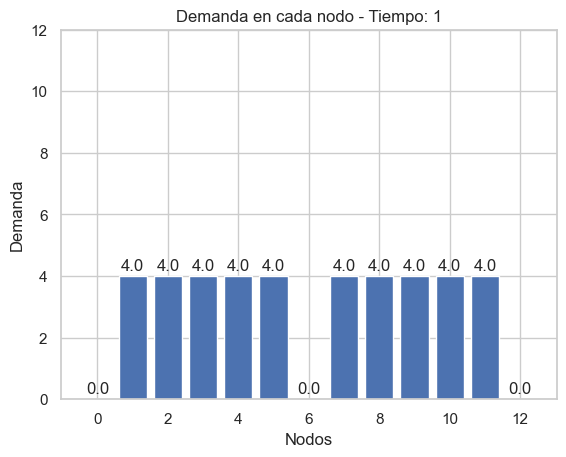

In [21]:
nodos = sorted(set(n for n, _ in valores_D.keys()))
tiempos = sorted(set(t for _, t in valores_D.keys()))

# Inicializar la figura y ejes
fig, ax = plt.subplots()
bars = ax.bar(nodos, [0] * len(nodos))  # Inicializar las barras con valores cero
ax.set_xlabel("Nodos")
ax.set_ylabel("Demanda")
ax.set_title("Demanda en cada nodo a lo largo del tiempo")

# Configurar límites del eje Y basado en los valores de demanda
ax.set_ylim(0, max(valores_D.values()) + 1)

# Etiquetas dinámicas para los valores sobre las barras
value_texts = [ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '', 
                       ha='center', va='bottom') for bar in bars]

def update(t):
    y_data = [valores_D.get((n, t), 0) for n in nodos]
    for bar, y, text in zip(bars, y_data, value_texts):
        bar.set_height(y)
        text.set_text(f'{y:.1f}')
        text.set_y(y + 0.1)  # Coloca la etiqueta justo encima de la barra
    ax.set_title(f"Demanda en cada nodo - Tiempo: {t}")

# Crear la animación
ani = FuncAnimation(fig, update, frames=tiempos, repeat=False)

# Guardar la animación como un archivo GIF
writer = PillowWriter(fps=1) 
ani.save(f'./outputs/gifs/demand_node/{ruta}.gif', writer=writer)

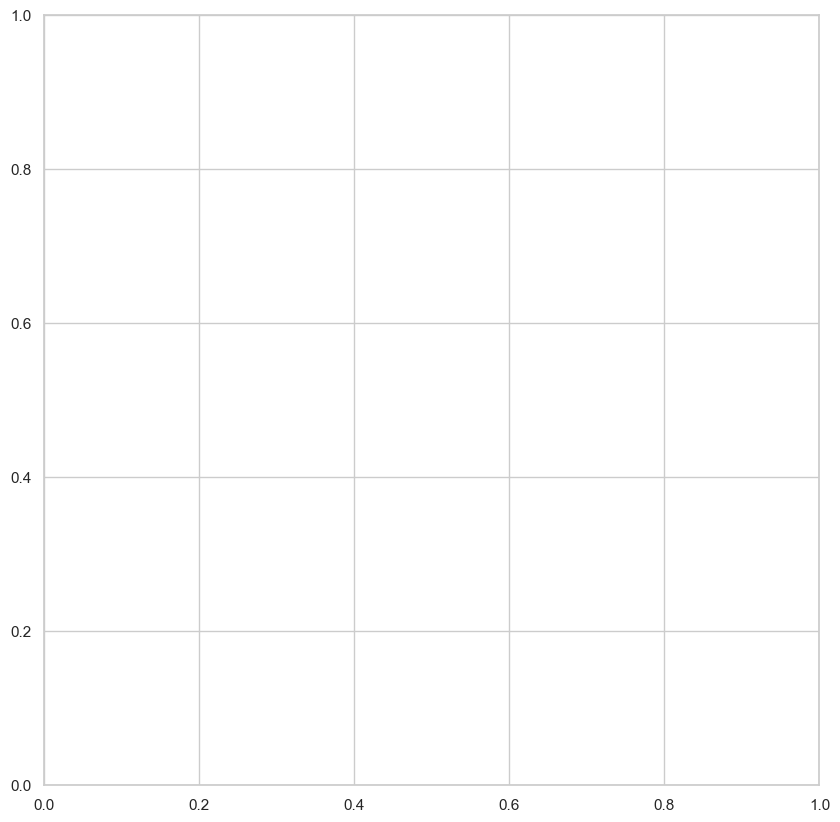

La animación ha sido guardada como 'demanda_actual_buses.gif'.


In [22]:
# Cargar la imagen del autobús (asegúrate de tener este archivo)
bus_img = mpimg.imread('./outputs/icons/bus_icon.png')

# Crear una función para obtener la imagen del autobús
def get_bus_image():
    return OffsetImage(bus_img, zoom=0.05)  # Ajusta el zoom según el tamaño del gráfico

# Variables iniciales
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(A)
pos = nx.circular_layout(G)  # Posiciones de los nodos en un círculo

# Inicializar la figura y ejes
fig, ax = plt.subplots(figsize=(10, 10))

# Asignar colores únicos a cada bus
colores_buses = {p: plt.cm.tab10(i % 10) for i, p in enumerate(P)}

# Función de inicialización
def init():
    # Dibujar nodos y etiquetas
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, ax=ax)
    return []

# Función para actualizar cada cuadro de la animación
def update(frame):
    ax.clear()
    
    # Dibujar nodos, etiquetas y arcos nuevamente
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax)
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, ax=ax)
    
    # Mostrar el valor actual de la demanda D en cada nodo como un número en una cajita
    for n in N:
        demanda_actual = valores_D.get((n, frame), 0)  # Valor de demanda en el nodo y tiempo actual
        ax.text(pos[n][0] + 0.1, pos[n][1], f'{int(demanda_actual)}', 
                fontsize=12, ha='center', va='center', bbox=dict(facecolor='lightyellow', edgecolor='black'))
    
    # Mostrar los buses en movimiento y su ocupación
    for p in P:
        nodos_bus = [n for n in N if presencia_bus.get((n, frame, p), 0) > 0.5]
        for n in nodos_bus:
            # Añadir el ícono del bus en el nodo
            imagebox = AnnotationBbox(get_bus_image(), pos[n], frameon=False, box_alignment=(0.5, 0.5))
            ax.add_artist(imagebox)
            
            # Mostrar ocupación actual del bus
            ocupacion_actual = valores_s.get((frame, p), 0)
            ax.text(pos[n][0] - 0.1, pos[n][1] + 0.1, f'{int(ocupacion_actual)} pax', 
                    ha='center', color=colores_buses[p], fontsize=10)
    
    # Título con el tiempo actual
    ax.set_title(f'Demanda Actual y Movimiento de Buses - Tiempo: {frame}')
    ax.axis('off')
    return []

# Crear la animación
ani = FuncAnimation(fig, update, frames=len(T), init_func=init, blit=False, repeat=False)

# Mostrar la animación en el entorno
plt.show()

# Guardar la animación como GIF (opcional)
try:
    writer = PillowWriter(fps=1)
    ani.save(f'./outputs/gifs/demand_bus/{ruta}.gif', writer=writer)
    print("La animación ha sido guardada como 'demanda_actual_buses.gif'.")
except Exception as e:
    print("Error al guardar la animación:", e)

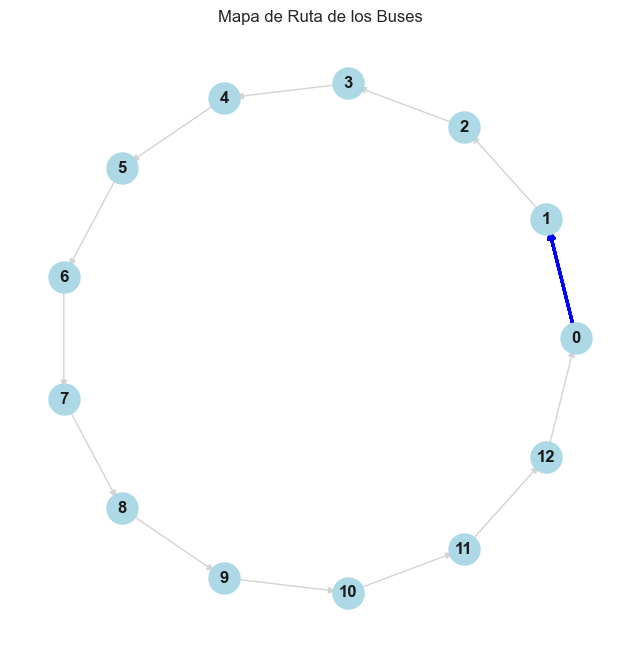

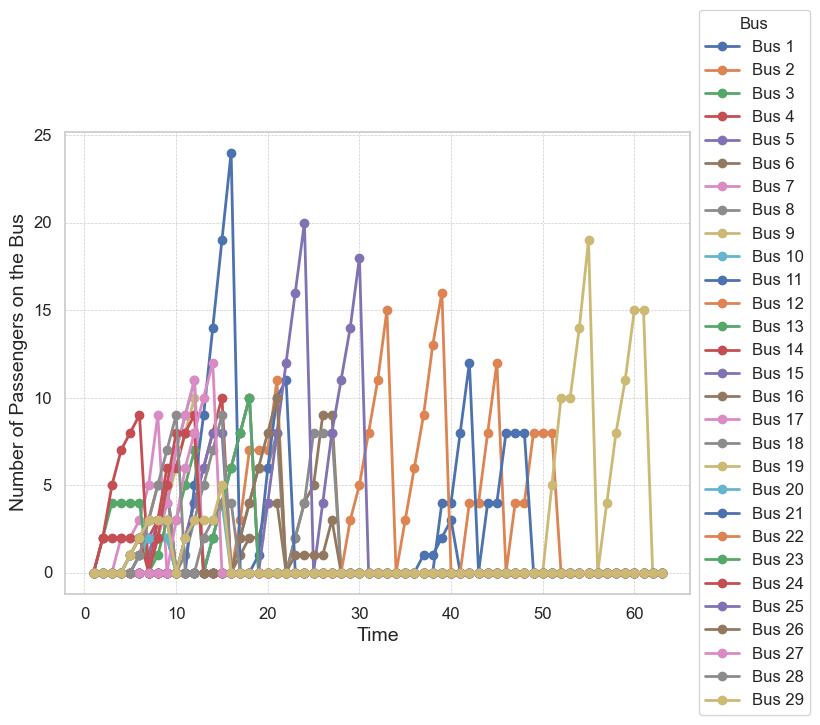

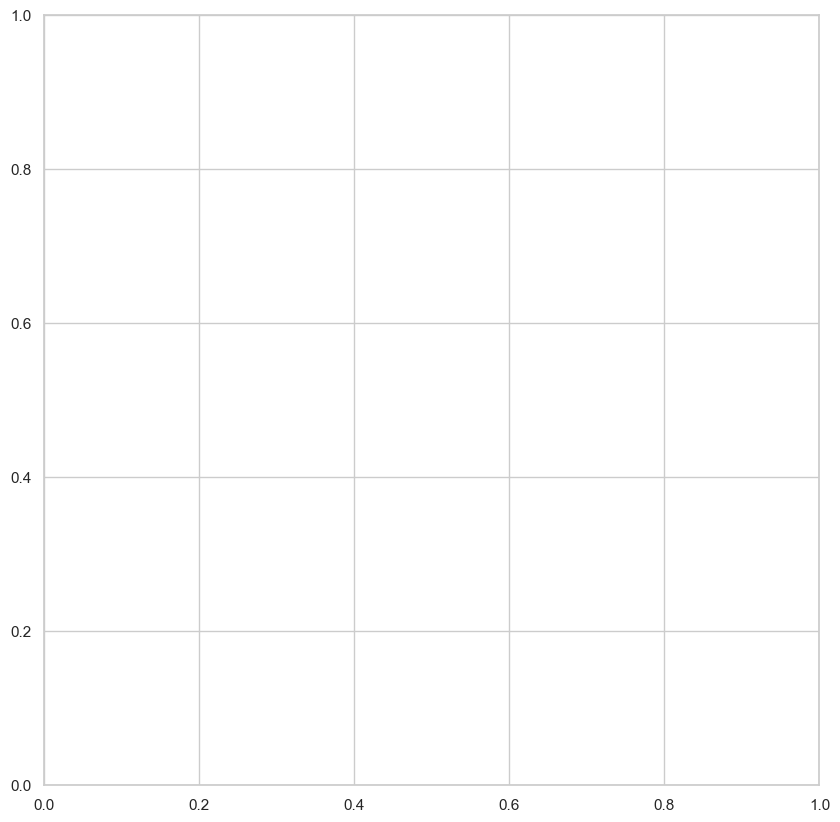

La animación ha sido guardada como 'bus_movement_animation.gif'.


In [26]:
# Suponiendo que N, T, P, A, tau, demanda, s_inicio, prop_bajada, capacidad_bus están definidos previamente

# Resolver el problema con PuLP
# ... (Tu código de PuLP para definir y resolver el problema) ...

# Después de resolver el problema, extraer los valores de las variables
valores_x = {(i, j, t, p): lp.value(x[(i, j, t, p)]) for (i, j, t, p) in x}
valores_z = {(n, t, p): lp.value(z[(n, t, p)]) for (n, t, p) in z}
valores_s = {(t, p): lp.value(s[(t, p)]) for (t, p) in s}

# Paso 1: Visualización del mapa de ruta del bus
G = nx.DiGraph()
G.add_nodes_from(N)
G.add_edges_from(A)

# Posiciones de los nodos en círculo para visualización
pos = nx.circular_layout(G)

# Crear una lista de arcos utilizados por cualquier bus
arcos_usados = [(i, j) for (i, j, t, p) in x if valores_x.get((i, j, t, p), 0) > 0.5]

# Dibujar el grafo
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
# Dibujar todos los arcos en gris claro
nx.draw_networkx_edges(G, pos, edge_color='lightgray', arrows=True)
# Resaltar los arcos utilizados en azul
nx.draw_networkx_edges(G, pos, edgelist=arcos_usados, edge_color='blue', arrows=True, width=2)
plt.title('Mapa de Ruta de los Buses')
plt.axis('off')
plt.show()

# Paso 2: Gráfico temporal de ocupación del bus

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Graficar ocupación para cada bus de acuerdo a los datos dados
for p in P:
    ocupacion = [valores_s.get((t, p), 0) for t in T]  # Usar tu diccionario valores_s
    plt.plot(T, ocupacion, marker='o', label=f'Bus {p}', linewidth=2)

# Mejoras en los títulos y etiquetas (en inglés para el paper)
#plt.title('Bus Occupancy Over Time', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of Passengers on the Bus', fontsize=14)

# Mejorar la leyenda y colocarla fuera del gráfico para una presentación más formal
plt.legend(title="Bus", loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Ajustes estéticos adicionales
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Rejilla más sutil
plt.xticks(fontsize=12)  # Ajustar tamaño de los ticks en el eje x
plt.yticks(fontsize=12)  # Ajustar tamaño de los ticks en el eje y

# Agregar margen adicional para acomodar la leyenda fuera del gráfico
plt.subplots_adjust(right=0.75)

# Guardar la figura en alta calidad (recomendado para papers)
# plt.savefig('bus_occupancy_paper.png', dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()

# Paso 3: Preparar los íconos de autobús
# Cargar la imagen del autobús
bus_img = mpimg.imread('./outputs/icons/bus_icon.png')  # Asegúrate de tener este archivo

# Crear una lista de imágenes para cada bus
def get_bus_image():
    return OffsetImage(bus_img, zoom=0.1)  # Ajusta el zoom según el tamaño del gráfico

# Paso 4: Animación del movimiento del bus
# Preparar datos para la animación
presencia_bus = {(n, t, p): valores_z.get((n, t, p), 0) for n in N for t in T for p in P}

fig_anim, ax_anim = plt.subplots(figsize=(10, 10))

# Asignar colores únicos a cada bus
colores_buses = {p: plt.cm.tab10(i % 10) for i, p in enumerate(P)}

# Inicializar la animación dibujando el grafo
def init_anim():
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax_anim)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax_anim)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', arrows=True, ax=ax_anim)
    # Resaltar los arcos utilizados en azul
    nx.draw_networkx_edges(G, pos, edgelist=arcos_usados, edge_color='blue', arrows=True, width=2, ax=ax_anim)
    return []

# Función para actualizar cada frame de la animación
def update_anim(frame):
    ax_anim.clear()
    # Dibujar nodos y arcos nuevamente
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue', ax=ax_anim)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold', ax=ax_anim)
    nx.draw_networkx_edges(G, pos, edge_color='lightgray', arrows=True, ax=ax_anim)
    # Resaltar los arcos utilizados en azul
    nx.draw_networkx_edges(G, pos, edgelist=arcos_usados, edge_color='blue', arrows=True, width=2, ax=ax_anim)
    
    # Resaltar la posición de cada bus con el ícono
    for p in P:
        nodos_bus = [n for n in N if presencia_bus.get((n, frame, p), 0) > 0.5]
        for n in nodos_bus:
            # Añadir el ícono del bus en la posición del nodo
            imagebox = AnnotationBbox(get_bus_image(), pos[n], frameon=False, box_alignment=(0.5, 0.5))
            ax_anim.add_artist(imagebox)
            # Añadir etiqueta de ocupación cerca del bus
            ocupacion_actual = valores_s.get((frame, p), 0)
            ax_anim.text(pos[n][0], pos[n][1]+0.1, f'{int(ocupacion_actual)} pax', fontsize=20, ha='center', color=colores_buses[p])
    
    ax_anim.set_title(f'Movimiento de los Buses en el Tiempo {frame}', fontsize=16)
    ax_anim.axis('off')
    return []

# Crear la animación
ani_anim = FuncAnimation(fig_anim, update_anim, frames=T, init_func=init_anim, blit=False, repeat=False, interval=1000)

# Mostrar la animación en el entorno
plt.show()

# Guardar la animación en un archivo GIF usando PillowWriter
try:
    writer = PillowWriter(fps=1)  # Ajusta fps según tus necesidades
    ani_anim.save(f'./outputs/gifs/bus_occupacy_over_time/{ruta}.gif', writer=writer)
    print("La animación ha sido guardada como 'bus_movement_animation.gif'.")
except Exception as e:
    print("Error al guardar la animación:", e)
    print("Asegúrate de tener Pillow instalado: pip install pillow")


In [24]:
dict_x = {}
for (i, j, t, p), variable in x.items():
    if lp.value(variable) > 0:  # Check if the variable's value is greater than zero
        dict_x[(i, j, t, p)] = variable.varValue 

In [25]:
dict_x

{(0, 1, 35, 1): 1.0,
 (0, 1, 40, 2): 1.0,
 (0, 1, 4, 3): 1.0,
 (0, 1, 4, 4): 1.0,
 (0, 1, 4, 5): 1.0,
 (0, 1, 4, 6): 1.0,
 (0, 1, 3, 7): 1.0,
 (0, 1, 4, 8): 1.0,
 (0, 1, 7, 9): 1.0,
 (0, 1, 7, 10): 1.0,
 (0, 1, 37, 11): 1.0,
 (0, 1, 10, 12): 1.0,
 (0, 1, 1, 13): 1.0,
 (0, 1, 1, 14): 1.0,
 (0, 1, 23, 15): 1.0,
 (0, 1, 16, 16): 1.0,
 (0, 1, 7, 17): 1.0,
 (0, 1, 16, 18): 1.0,
 (0, 1, 50, 19): 1.0,
 (0, 1, 4, 20): 1.0,
 (0, 1, 11, 21): 1.0,
 (0, 1, 28, 22): 1.0,
 (0, 1, 7, 23): 1.0,
 (0, 1, 1, 24): 1.0,
 (0, 1, 19, 25): 1.0,
 (0, 1, 16, 26): 1.0,
 (0, 1, 9, 27): 1.0,
 (0, 1, 5, 28): 1.0,
 (0, 1, 4, 29): 1.0}

In [ ]:
np.sum(list(demanda.values()))
lp.value(prob.objective)

360.0

In [ ]:
dict_s = {}
for (t, p), variable in s.items():
    if lp.value(variable) > 0 and p in [1,2,3]:  # Check if the variable's value is greater than zero
        dict_s[(t, p)] = variable.varValue 